#INSTALL PYTHON PACKAGES

In [1]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#IMPORT IMPORTANT PACKAGES

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import SpecificityAtSensitivity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import opendatasets as od
import matplotlib as mpl
import shutil


#GLOBAL VARIABLE

In [3]:
dataset_kaggle_url = "https://www.kaggle.com/tawsifurrahman/covid19-radiography-database"
dataset_folder_path = "covid19-radiography-database/COVID-19_Radiography_Dataset"

#DOWNLOAD DATASET

In [ ]:
# download dataset for kaggle
od.download(dataset_kaggle_url)

##DELETE FILES and FOLDERS

In [6]:
files_not_important = ["COVID.metadata.xlsx", 
                       "Lung_Opacity.metadata.xlsx",
                       "Normal.metadata.xlsx",
                       "README.md.txt",
                       "Viral Pneumonia.metadata.xlsx"]
for i in files_not_important:
  os.remove(os.path.join(dataset_folder_path, i))

In [59]:
files_not_important = [
                       "COVID/masks",
                       "Lung_Opacity",
                       "Normal",
                       "Viral Pneumonia/masks"]
for i in files_not_important:
  shutil.rmtree(os.path.join(dataset_folder_path, i), ignore_errors=True)

#Read Dataset Images

In [8]:
def dataset_images_path(dataset_folder_path):
  paths = []
  for dirname, _, filenames in os.walk(dataset_folder_path):
      for filename in filenames:
          paths.append(os.path.join(dirname, filename))
  return paths

In [9]:
images = dataset_images_path(dataset_folder_path)
img = cv2.imread(images[0])

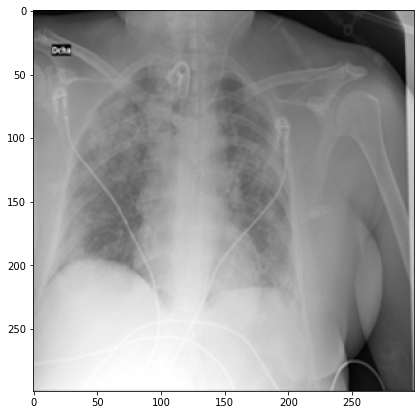

In [10]:
plt.figure(figsize=(7,7))
plt.imshow(img)
plt.show()

In [11]:
img.shape

(299, 299, 3)

In [12]:
image_height = img.shape[0]
image_width = img.shape[1]
image_color = img.shape[2]

In [13]:
image_height = 224
image_width = 224

#Optimizing dataset images by using Histogram equalization

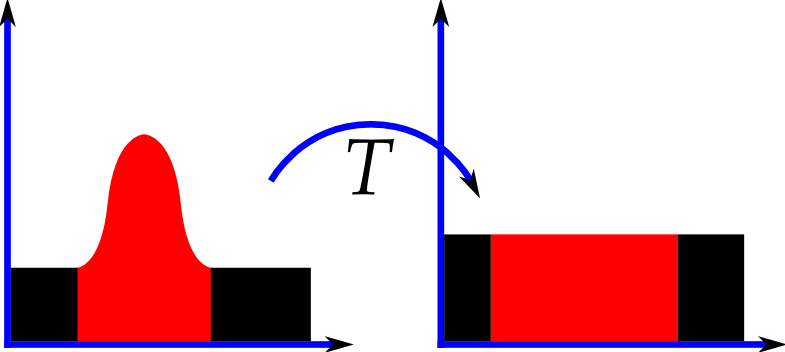

In [14]:
!mkdir dataset_after_histogram_equalization

In [15]:
new_dataset_folder_after_equalization = "dataset_after_histogram_equalization"

In [16]:
for dirname, _, filenames in os.walk(dataset_folder_path):
          os.makedirs(os.path.join(new_dataset_folder_after_equalization, dirname))

In [17]:
for dirname, _, filenames in os.walk(dataset_folder_path):
      for filename in filenames:
        path = str(os.path.join(dirname, filename))
        img = cv2.imread(path)
        R, G, B = cv2.split(img)
        output1_R = cv2.equalizeHist(R)
        output1_G = cv2.equalizeHist(G)
        output1_B = cv2.equalizeHist(B)
        equ = cv2.merge((output1_R, output1_G, output1_B))
        image_after_processing = os.path.join(new_dataset_folder_after_equalization, dirname, filename)
        cv2.imwrite(image_after_processing, equ)

In [18]:
images_after_hist_equal = dataset_images_path(os.path.join(new_dataset_folder_after_equalization, dataset_folder_path))

In [19]:
img = cv2.imread(images_after_hist_equal[0])

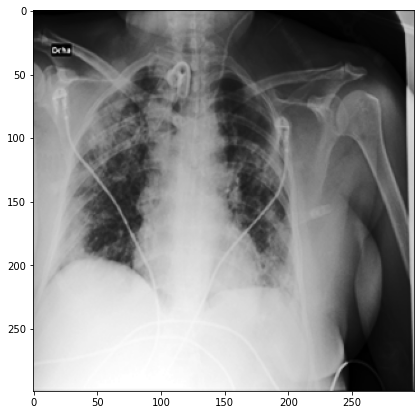

In [20]:
plt.figure(figsize=(7,7))
plt.imshow(img)
plt.show()

#IMAGE DATASET GENERATOR AND BUILD CNN MODEL

In [166]:
#preprocessing_function function
def changeRange(image):
   
   image[:, :, 0] = [(i - 127.5)/127.5 for i in image[:, :, 0]]
   image[:, :, 1] = [(i - 127.5)/127.5 for i in image[:, :, 1]]
   image[:, :, 2] = [(i - 127.5)/127.5 for i in image[:, :, 2]]
   

   return image
def dataset_image_generator2(dataset_folder):
  datagen = ImageDataGenerator( rescale=None,preprocessing_function=changeRange, validation_split=0.2, horizontal_flip=True,
                               rotation_range = 2, shear_range = 0.02,zoom_range = 0.02,zca_whitening=False, samplewise_center=True, samplewise_std_normalization= True)
  # datagen.fit(sample)
  train_generator = datagen.flow_from_directory(
      dataset_folder,
      target_size=(image_height, image_width),
      batch_size=32,
      class_mode='categorical',
      shuffle=True,
      subset='training')

  validation_generator = datagen.flow_from_directory(
      dataset_folder, 
      target_size=(image_height, image_width),
      batch_size= 32,
      shuffle=True,
      class_mode='categorical',
      subset='validation')
  return [train_generator, validation_generator]

In [62]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall')
]

In [72]:
def compile_model(model):
  learning_rate = 0.00001
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                loss='binary_crossentropy', metrics=METRICS)

In [73]:
from keras.callbacks import EarlyStopping, TensorBoard
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs")
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 70, mode = 'min', restore_best_weights = True)

In [74]:
def fit_model(model):
  history = model.fit(train_generator, validation_data=validation_generator, epochs=260, batch_size = 32, callbacks=[earlyStopping])
  return history

In [122]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix
def confusion_matrix_calculate(model, validation_generator):
  target_names = ['COVID','Viral Pneumonia']
  label_names = [0,1]
  Y_pred = model.predict(
            validation_generator, batch_size = 32, verbose = 0, steps = validation_generator.n//validation_generator.batch_size)
  y_pred = np.argmax(Y_pred ,  axis = 1)
  cm = confusion_matrix(validation_generator.classes, y_pred, labels = label_names)
  disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=target_names)
  disp = disp.plot(cmap=plt.cm.Blues, values_format = 'g')
  plt.show()

#TRAINING FOR DATASET WITH ENHANCMENT

In [167]:
[train_generator, validation_generator] = dataset_image_generator2(
    os.path.join(new_dataset_folder_after_equalization, dataset_folder_path))

Found 3969 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [174]:
def getSamplesd(resultData):
    x = resultData.next()
    a = x[0] 
    b = x[1] 
    for i in range(0,1):
        print(a[i])
        print(b[i]) 

In [160]:
def getSamplesFromDataGen(resultData):
    x = resultData.next() #fetch the first batch
    a = x[0] # train data
    b = x[1] # train label
    for i in range(0,15):
        plt.grid(b=None)
        plt.imshow(a[i])
        plt.title(b[i])
        plt.show() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


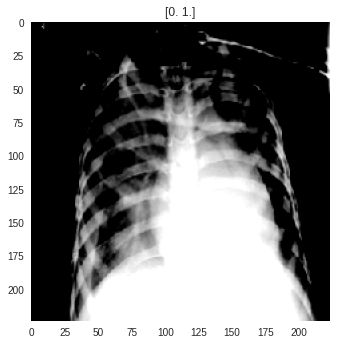

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


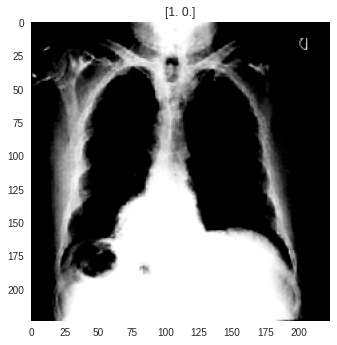

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


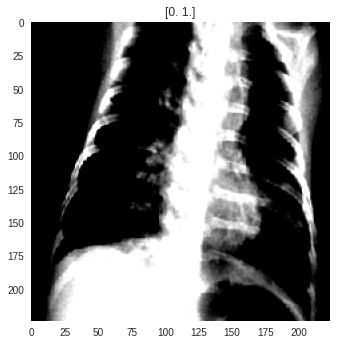

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


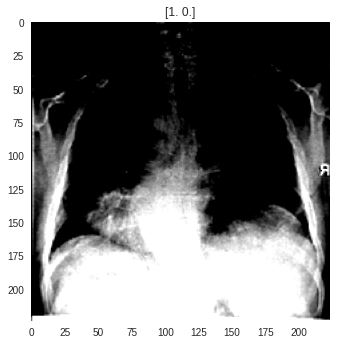

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


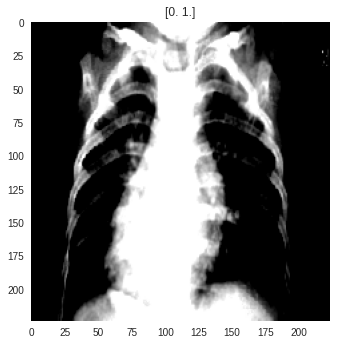

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


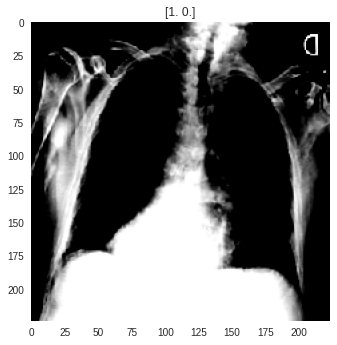

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


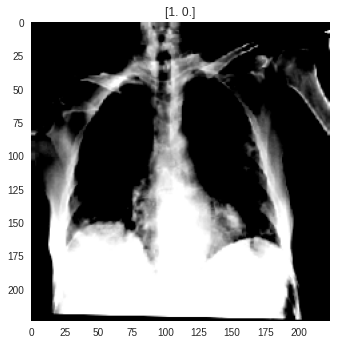

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


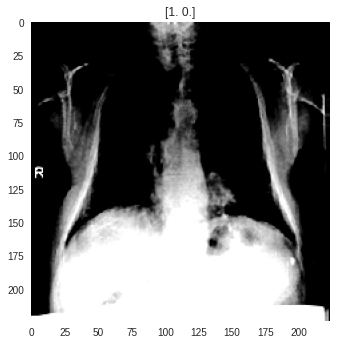

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


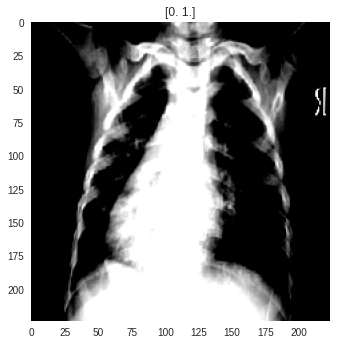

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


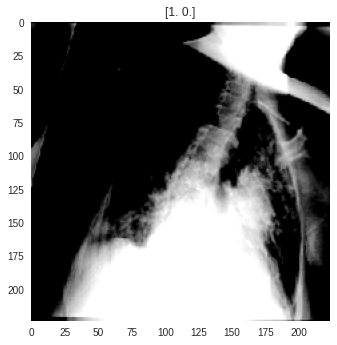

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


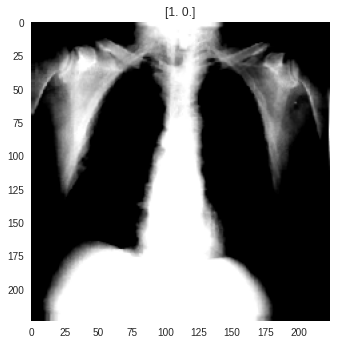

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


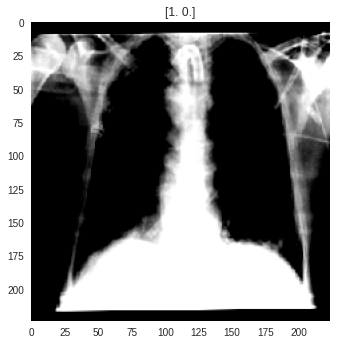

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


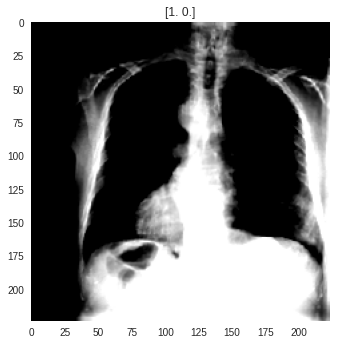

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


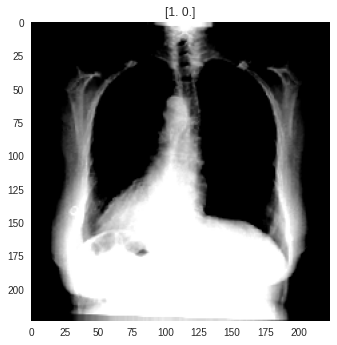

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


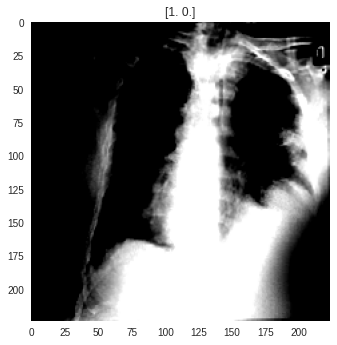

In [169]:
getSamplesFromDataGen(train_generator)

In [175]:
getSamplesd(train_generator)

[[[ 1.3316145   1.3316145   1.3316145 ]
  [ 1.3322297   1.3322297   1.3322297 ]
  [ 0.23422438  0.23422438  0.23422438]
  ...
  [-1.6881896  -1.6881896  -1.6881896 ]
  [-1.6881896  -1.6881896  -1.6881896 ]
  [-1.6881896  -1.6881896  -1.6881896 ]]

 [[ 1.2961292   1.2961292   1.2961292 ]
  [ 1.2970521   1.2970521   1.2970521 ]
  [ 0.1913162   0.1913162   0.1913162 ]
  ...
  [-1.6881896  -1.6881896  -1.6881896 ]
  [-1.6881896  -1.6881896  -1.6881896 ]
  [-1.6881896  -1.6881896  -1.6881896 ]]

 [[ 1.282428    1.282428    1.282428  ]
  [ 1.282428    1.282428    1.282428  ]
  [ 0.14692467  0.14692467  0.14692467]
  ...
  [-1.6881896  -1.6881896  -1.6881896 ]
  [-1.6881896  -1.6881896  -1.6881896 ]
  [-1.6881896  -1.6881896  -1.6881896 ]]

 ...

 [[-1.1564196  -1.1564196  -1.1564196 ]
  [-1.186867   -1.186867   -1.186867  ]
  [-1.1247101  -1.1247101  -1.1247101 ]
  ...
  [-1.2437276  -1.2437276  -1.2437276 ]
  [-0.74727    -0.74727    -0.74727   ]
  [-0.74727    -0.74727    -0.74727   ]]

 [

In [78]:
classes_names = list(train_generator.class_indices)

#Transfer learning

In [79]:
import tensorflow.keras as keras
from tensorflow.keras import regularizers

## DenseNet121 Pre-trained Model

In [80]:
from keras.models import Sequential, load_model
from tensorflow.keras.initializers import GlorotNormal
def pre_trained_desnet():
  densenet = keras.applications.densenet
  conv_model = densenet.DenseNet121(weights=None, include_top=False, pooling="avg", input_shape=(224,224,3))
  x = keras.layers.Dropout(0.3)(conv_model.output)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(64, activation='tanh',kernel_initializer=GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(32, activation='tanh',kernel_initializer=GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001) ,kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(16, activation='tanh',kernel_initializer=GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001) ,kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(classes_names), activation='softmax', kernel_initializer=GlorotNormal(), bias_regularizer=tf.keras.regularizers.L2(0.0001),kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))(x)
  densenet_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
  for layer in densenet_model.layers[:300]:
      layer.trainable = False
  for layer in densenet_model.layers[300:]:
      layer.trainable = True
  # https://www.kaggle.com/datasets/theewok/chexnet-keras-weights    
  densenet_model.load_weights("drive/MyDrive/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name = True, skip_mismatch = True)
  densenet_model.summary()
  return densenet_model

In [81]:
desnet = pre_trained_desnet()
compile_model(desnet)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [82]:
densenet_history2 = fit_model(desnet)

Epoch 1/260
125/125 [==============================] - 93s 659ms/step - loss: 0.7379 - tp: 2517.0000 - fp: 1452.0000 - tn: 2517.0000 - fn: 1452.0000 - accuracy: 0.6342 - precision: 0.6342 - recall: 0.6342 - val_loss: 0.5997 - val_tp: 723.0000 - val_fp: 269.0000 - val_tn: 723.0000 - val_fn: 269.0000 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 0.7288
Epoch 2/260
125/125 [==============================] - 78s 628ms/step - loss: 0.6846 - tp: 2788.0000 - fp: 1181.0000 - tn: 2788.0000 - fn: 1181.0000 - accuracy: 0.7024 - precision: 0.7024 - recall: 0.7024 - val_loss: 0.6038 - val_tp: 723.0000 - val_fp: 269.0000 - val_tn: 723.0000 - val_fn: 269.0000 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 0.7288
Epoch 3/260
125/125 [==============================] - 78s 622ms/step - loss: 0.6769 - tp: 2841.0000 - fp: 1128.0000 - tn: 2841.0000 - fn: 1128.0000 - accuracy: 0.7158 - precision: 0.7158 - recall: 0.7158 - val_loss: 0.6080 - val_tp: 723.0000 - val_fp: 269.0000 - 

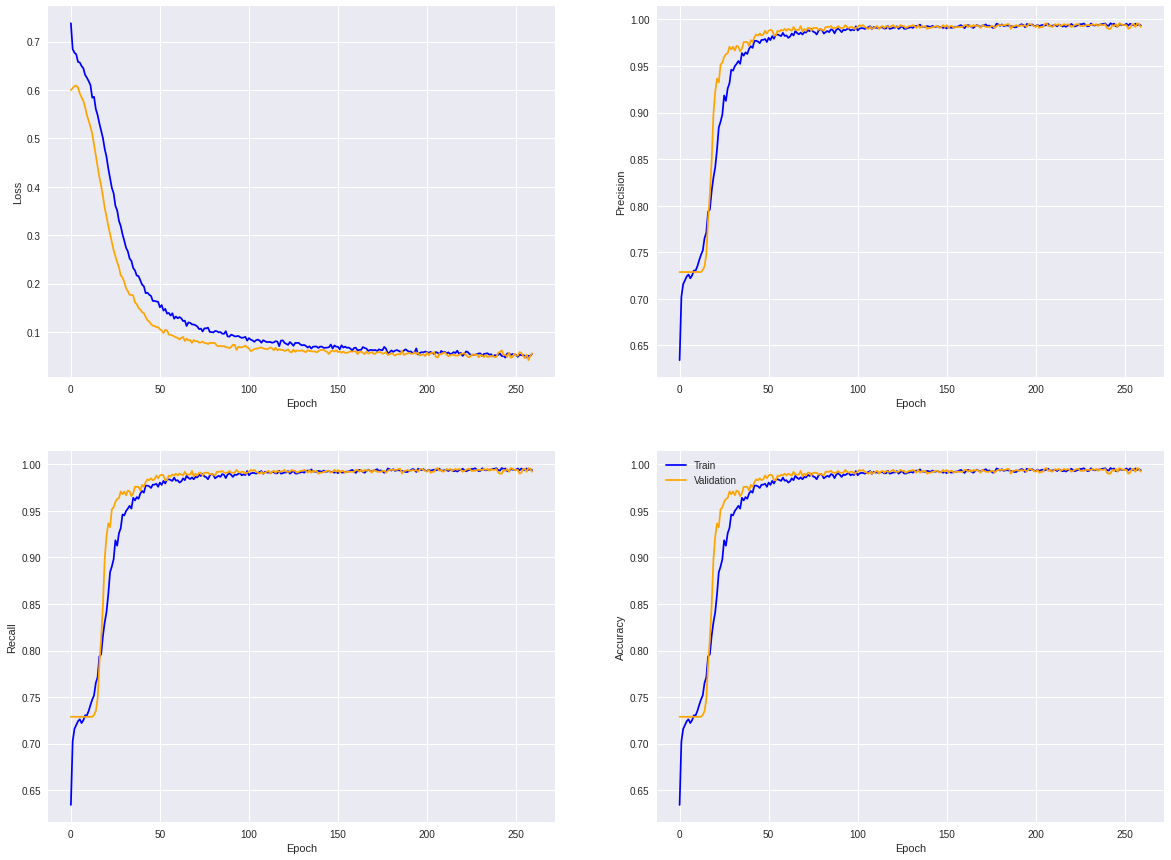

In [139]:
def plot_res(history):
    metrics =  ['loss', 'precision', 'recall','accuracy']
    mpl.style.use('seaborn')
    plt.figure(figsize = (20, 15))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.history[metric],'blue', label='Train')
        plt.plot(history.history['val_'+metric],'orange', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    plt.legend()

plot_res(densenet_history2)

In [125]:
desnet.evaluate(validation_generator,batch_size = 32,
                workers = 1, 
                steps = validation_generator.n // validation_generator.batch_size)

31/31 [==============================] - 16s 519ms/step - loss: 0.0445 - tp: 988.0000 - fp: 4.0000 - tn: 988.0000 - fn: 4.0000 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960


[0.04454178735613823,
 988.0,
 4.0,
 988.0,
 4.0,
 0.9959677457809448,
 0.9959677457809448,
 0.9959677457809448]